As an introduction to tensorflow, let's use tensorflow to classify MNIST numerals. However, we will not be using keras -- while keras simplifies constructing basic neural networks, it decreases flexibility that we may need in the future (e.g., when we try to model optical processes). I will try keep this introduction as simple as possible without including too many extra features that, while likely to be useful, may distract you from getting something running for the first time. Once we get the basics down, in the future we can revisit some of the helpful tools, such as graph visualization and tensorboard.

# import data

In [3]:
import os
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def read_feature(folder, num):
    filename = glob.glob(os.path.join(folder, '*'))
    img_arr = np.zeros([len(filename), 100, 100, 3])
    label = num * np.ones(len(filename), dtype="float32")
    for i, name in enumerate(filename):
        img = Image.open(name)
        img_arr[i, :, :, :] = np.asarray(img, dtype="uint8")
    return img_arr, label

import os
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def read_feature(folder, num):
    filename = glob.glob(os.path.join(folder, '*'))
    img_arr = np.zeros([len(filename), 100, 100, 3])
    label = num * np.ones(len(filename), dtype="float32")
    for i, name in enumerate(filename):
        img = Image.open(name)
        img_arr[i, :, :, :] = np.asarray(img, dtype="float32")
    return img_arr, label


(8076, 100, 100, 3)
(8076,)
Training data shape (7268, 100, 100, 3)
(7268, 100, 100, 3)
(7268,)
(808, 100, 100, 3)
(808,)


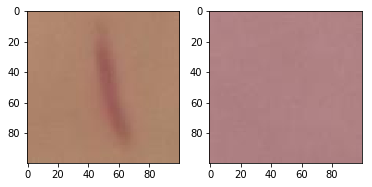

In [4]:
tb_img_arr, tb_label = read_feature('./TB_Image', 1)
non_tb_img_arr, non_tb_label = read_feature('./Non-TB_Image', 0)
images = np.concatenate((tb_img_arr, non_tb_img_arr))
labels = np.concatenate((tb_label, non_tb_label))

print(np.shape(images))
print(np.shape(labels))
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1)

X_train = X_train.astype(np.int)
X_val = X_val.astype(np.int)
y_train = y_train.astype(np.int)
y_val = y_val.astype(np.int)

print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0,:,:,:]);
ax2.imshow(X_train[1,:,:,:]/255);

# verify that the shapes are correct:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

# add a channels dimension:
# X_train = X_train[..., None]
# X_val = X_val[..., None]

# symbolically generate a batch of images and labels

In [5]:
# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.float32, [None, 100, 100, 3], name='input_image')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = 32

# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

Instructions for updating:
Colocations handled automatically by placer.


# given a symbolic batch, symbolically process it through a network and output the loss

In [6]:
net = X_batch

# add some convolutional layers:
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# add some more if you want:
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# fully connected layers:
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=512, activation=tf.nn.relu)
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=2)

logits = net

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=2), logits=logits)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.


# given a loss, create an op that, when run, descends the gradient by one step

In [7]:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.0001).minimize(loss)

# start a tensorflow session and use it to initialize all <u>variables</u> and <u>ops</u>

In [8]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# do gradient descent: run a train loop over multiple iterations

In [12]:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})

correct = 0
total = 0
for i in range(100):
    _, loss_i = sess.run([train_op, loss])
    prediction, truth = sess.run([logits, y_batch])
    correct += np.sum(prediction.argmax(1)==truth)
    total += len(truth)
    if i%50 == 0:
        print(loss_i)
acc = correct/total
print('accuracy is ', acc)

0.54939544
0.5568181
accuracy is  0.74


In [9]:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})

correct = 0
total = 0
for i in range(1001):
    try:
        _, loss_i = sess.run([train_op, loss])
        prediction, truth = sess.run([logits, y_batch])
        correct += np.sum(prediction.argmax(1)==truth)
        total += len(truth)
        if i%200 == 0:
            print(loss_i)
    except tf.errors.OutOfRangeError:
        pass
acc = correct/total
print('accuracy is ', acc)

12.449474
accuracy is  0.5790055248618785


# pass through the validation set

In [8]:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_test, y_train_or_test: y_test})
correct = 0
total = 0
for i in range(1):
    prediction, truth = sess.run([logits, y_batch])
    correct += np.sum(prediction.argmax(1)==truth)
    total += len(truth)
acc = correct/total
print(acc)

NameError: name 'X_test' is not defined